In [1]:
import gym
import gym_stock_exchange
import random
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('game-stock-exchange-v0')

In [2]:
from functools import partial
from copy import deepcopy
import datetime
from itertools import count
import math
import logging
import matplotlib.pyplot as plt
import numpy as np
from random import choice
import time
from utils import device, train_dqn
import seaborn as sns
from collections import deque

In [3]:
from utils import ReplayMemory
import torch.optim as optim

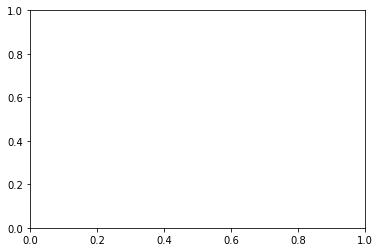

In [4]:
env.create_engine('aapl', '2014-01-01', 1000, num_action_space=5)

In [5]:
FEATURES = 512
class DuelingDQN(nn.Module):
    # Eventually, n_tickers should create n number of values and advantages
    def __init__(self, n_input_features, n_action_space, n_tickers=None):
        super(DuelingDQN, self).__init__()
        self.n_action_space = n_action_space
        self.feature = nn.Sequential(
            nn.Linear(n_input_features, FEATURES),
            nn.ReLU(),
            nn.Linear(FEATURES, FEATURES),
            nn.ReLU(),
            nn.Linear(FEATURES, FEATURES),
            nn.ReLU(),
        )

        self.value = nn.Sequential(
            nn.Linear(FEATURES, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.advantage = nn.Sequential(
            nn.Linear(FEATURES, 32),
            nn.ReLU(),
            nn.Linear(32, n_action_space)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value(x)
        advantage = self.advantage(x)
        return value + advantage - advantage.mean()

    def predict(self, x):
        return self.forward(x).detach().sort(dim=1, descending=True)

    def act(self, x, epsilon):
        if not torch.is_tensor(x):
            x = torch.tensor([x], dtype=torch.float32, device=device)
        if np.random.rand() > epsilon:
            x = self.feature(x).detach()
            x = self.advantage(x).detach().argmax().item()
            return x
        else:
            return np.random.randint(self.n_action_space)

In [16]:
EPS_MAX, EPS_MIN, DECAY_DELAY = 1.0, 0.01, 1000
def eps_decay_original(eps_max, eps_min, decay_delay, cur_iter):
    return eps_min + (eps_max - 
                      eps_min) * math.exp(-1.0 * cur_iter / decay_delay)
eps_decay = partial(eps_decay_original, EPS_MAX, EPS_MIN, DECAY_DELAY)

In [7]:
from IPython.display import clear_output
def plot(frame_idx, rewards, losses, eps):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s eps: %s' % (frame_idx, np.mean(rewards[-10:]), eps))
    plt.scatter(np.arange(len(rewards)), rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

In [22]:
def get_running_state(num_days):
    return np.zeros(num_days).tolist()

def add_new_state(running_state_orig, new_state_to_add):
    if isinstance(new_state_to_add, list):
        new_state_to_add = new_state_to_add[0]
        
    running_state = pd.Series(running_state_orig).shift(-1)
    
    # Assign new price to index == last_elem - 1
    running_state.iloc[-2] = new_state_to_add.item(0)
    # Assign new position to index == last_elem
    running_state.iloc[-1] = new_state_to_add.item(1)
    
    assert len(running_state_orig) == len(running_state)
    
    return running_state.tolist()

# Actual days will be 19 days, plus one spot for position variable
NUM_RUNNING_DAYS = 20

def run_exchange(env, policy_q, traget_q, replay_memory,
                 batch_size, optimizer, gamma, 
                 double_dqn=True, mode='train', num_frames=20):

    losses = []
    all_rewards = []
    
    episode_reward = 0
    running_state = get_running_state(NUM_RUNNING_DAYS)
    
    state = env.reset()
    running_state = add_new_state(running_state, state)
    
    for idx in range(1, num_frames + 1):
        this_episode_losses = []
        for t in count(1):
            if mode =='train':
                epsilon = eps_decay(idx)
            else:
                epsilon = 1e-8

            action = policy_q.act(running_state, epsilon)

            next_state, reward, done, _ = env.step(action)
            
            # copy t_0 so that we don't change t_1 variable
            running_state_0 = deepcopy(running_state)
            running_state = add_new_state(running_state, next_state)
            
            # make it a series then del?
            assert not pd.Series(running_state).hasnans, \
                        pd.Series(running_state).isnull()
            assert running_state_0[1:-1] == running_state[:-2], \
                '{} vs \n {}'.format(running_state_0[1:], running_state[:-1])
            
            replay_memory.push(running_state_0, action, 
                               running_state, reward)

            episode_reward += reward

            if mode == 'train':
                loss = train_dqn(policy_q, traget_q, replay_memory,
                             batch_size, optimizer, gamma, double_dqn)
                if loss is not None:
                    this_episode_losses += [loss.item()]

            if done:
                all_rewards.append(episode_reward)
                
                episode_reward = 0
                
                del running_state
                running_state = get_running_state(NUM_RUNNING_DAYS)

                state = env.reset()
                running_state = add_new_state(running_state, state)
            
                losses += [np.mean(this_episode_losses)]
                del this_episode_losses
            
                if idx % 2 == 0:
                    plot(idx, all_rewards, losses, epsilon)
                
                if idx % 100 == 0:
                    target_q.load_state_dict(policy_q.state_dict())

                break


In [9]:
policy_q, target_q = DuelingDQN(NUM_RUNNING_DAYS, 5).cuda(), \
                        DuelingDQN(NUM_RUNNING_DAYS, 5).cuda()
rm = ReplayMemory(100000)

In [ ]:
try:
    policy_q.load_state_dict(torch.load('my_duel_policy_vanila.pt'))
    target_q.load_state_dict(torch.load('my_duel_target_vanila.pt'))
except FileNotFoundError:
    print('--- Files Not Found ---')

In [10]:
optimizer = optim.RMSprop(policy_q.parameters(), eps=1e-7)

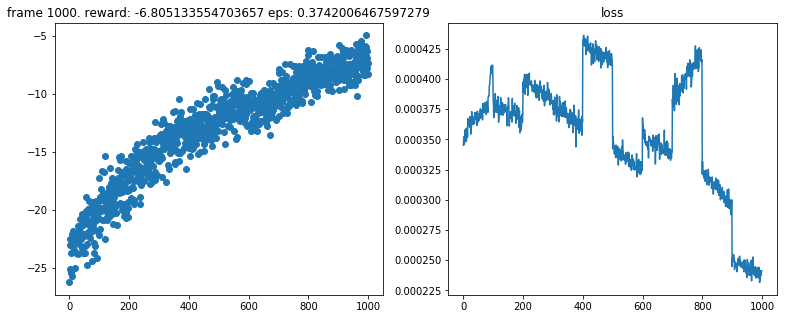

In [19]:
run_exchange(env, policy_q, target_q, rm, 32, 
             optimizer, 1.0, num_frames=1000)

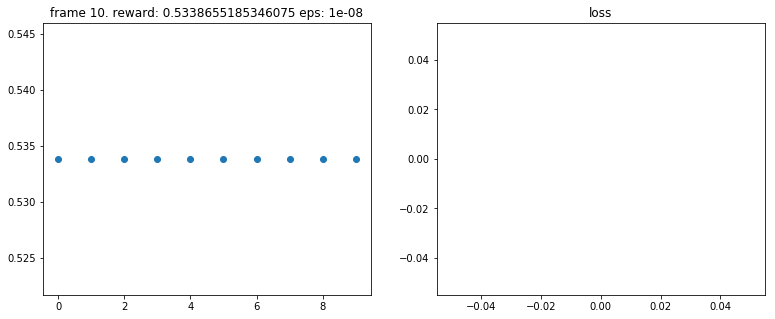

In [23]:
run_exchange(env, policy_q, target_q, rm, 32, optimizer, 1.0, mode='test', num_frames=10)

In [24]:
torch.save(policy_q.state_dict(), 'my_duel_policy_vanila.pt')
torch.save(target_q.state_dict(), 'my_duel_target_vanila.pt')